In [1]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip


--2023-05-15 09:57:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.11MB/s    in 2m 40s  

2023-05-15 10:00:06 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [2]:
!unzip -u glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [8]:
import pandas as pd
import re

dataset = pd.read_csv('file.csv')

#first step is to clean dataset to remove the unwanted characater like _ , etc..

# Clean the text in all columns
for column in dataset.columns:
    dataset[column] = dataset[column].apply(lambda x: re.sub(r"[^a-zA-Z0-9]", " ", str(x)))

# Save the cleaned DataFrame back to a CSV file
dataset.to_csv('cleaned_file.csv', index=False)


In [9]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

#second step is to lemmatize the dataset to split into words 

lemmatizer = WordNetLemmatizer()             

for column in dataset.columns:
    dataset[column] = dataset[column].apply(lambda x: [lemmatizer.lemmatize(word) for word in word_tokenize(x)])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [10]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.models import Model

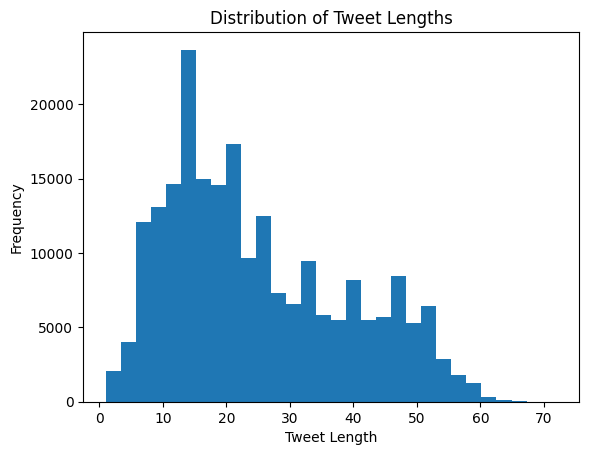

In [11]:

# analyze the distribution of tweet lengths
import matplotlib.pyplot as plt

tweet_lengths = dataset['tweets'].apply(len)

# Plot a histogram of tweet lengths
plt.hist(tweet_lengths, bins=30)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()


In [12]:
MAX_SEQUENCE_LENGTH = 70 # padding length of each tweet (to be updated )
MAX_NUM_WORDS = 20000       # take a  first  MAX_NUM_WORDS of tokenized words  (to be updated )

tweets = dataset['tweets'].values
labels = dataset['labels'].values

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(tweets)


In [13]:
#converts a list of texts into sequences of integers. unique word assigned a unique integer index.
index_sequences = tokenizer.texts_to_sequences(tweets)


In [14]:
word_index_dictionary = tokenizer.word_index # the dictionary

#only top MAX_SEQUENCE_LENGTH  will be used to generate the sequences 
data = pad_sequences(index_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of samples:', data.shape)
print(data[3])

Shape of samples: (219294, 70)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 5200    7  477   20    1   95   46  103 2756   15 2917   11   61  688
  242   10 1864    7  212    4    2    3    4    2    3    4    2    3]


In [15]:
from sklearn.preprocessing import LabelEncoder

labels = dataset['labels'].tolist()
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Print the encoded labels
print(encoded_labels)


# bad 0
# good 1 
# neutral 2 

[2 1 2 ... 0 0 2]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
labels_matrix = to_categorical(np.asarray(encoded_labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels_matrix.shape)
print('Sample label:\n',labels_matrix[4])

Shape of data tensor: (219294, 70)
Shape of label tensor: (219294, 3)
Sample label:
 [1. 0. 0.]


In [17]:
Test_SPLIT = 0.2
indices = np.arange(data.shape[0])

np.random.shuffle(indices)
data_shuffled = data[indices]
labels_shuffled = labels_matrix[indices]
nb_validation_samples = int(Test_SPLIT * data_shuffled.shape[0])
x_train = data_shuffled[:-nb_validation_samples]
y_train = labels_shuffled[:-nb_validation_samples]
x_val = data_shuffled[-nb_validation_samples:]
y_val = labels_shuffled[-nb_validation_samples:]
print('Shape of training data: ',x_train.shape)
print('Shape of testing data: ',x_val.shape)


Shape of training data:  (175436, 70)
Shape of testing data:  (43858, 70)


In [18]:
EMBEDDING_DIM = 200

embeddings_index = {}

# number of a glove dimensions to be changed 
with open('glove.6B.200d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
         
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [19]:
#initialize embedding_matrix with zeros 
embedding_matrix = np.zeros((len(word_index_dictionary) + 1, EMBEDDING_DIM))

for word, i in word_index_dictionary.items():
    embedding_vector = embeddings_index.get(word) # if the word is not in this dict. it will remain zeros
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print ('Shape of Embedding Matrix: ',embedding_matrix.shape)



Shape of Embedding Matrix:  (255624, 200)


In [20]:
embedding_matrix[12]

array([ 2.68049985e-01,  3.60320002e-01, -3.31999987e-01, -5.46419978e-01,
       -5.04509985e-01, -1.34610003e-02, -8.04319978e-01, -2.42139995e-01,
        5.37360013e-01,  7.75810003e-01, -3.25540006e-01,  4.83000010e-01,
        8.42649996e-01,  3.77799988e-01, -1.47670001e-01,  5.31920016e-01,
       -7.05179989e-01,  4.40369993e-01,  7.50349998e-01, -1.81710005e-01,
        7.01390028e-01,  2.93829989e+00,  4.56119999e-02, -2.11759999e-01,
        1.99469998e-01, -4.81750011e-01, -2.58150011e-01,  4.62000012e-01,
       -5.68410009e-03, -3.05629998e-01, -5.75410008e-01, -1.95269994e-02,
       -1.37510002e-01, -5.94500005e-01, -3.82160008e-01, -1.35409996e-01,
       -6.64439976e-01, -2.30279997e-01, -5.54660000e-02,  3.84209991e-01,
       -1.68880001e-01,  5.14619984e-02, -2.82929987e-01,  4.50760007e-01,
       -3.64639997e-01,  3.61009985e-01,  1.09350002e+00, -1.19470000e-01,
        4.97290008e-02,  4.87650000e-02,  4.89439994e-01, -3.31379997e-04,
        1.63650006e-01,  

In [21]:

embedding_layer = Embedding(len(word_index_dictionary) + 1, #vocab size
EMBEDDING_DIM, #embedding vector size
weights=[embedding_matrix], #weights matrix
input_length= MAX_SEQUENCE_LENGTH, trainable=False)#padded sequence length
                          

In [22]:
from keras.layers import LSTM

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(256, return_sequences=True)(embedded_sequences)
x = LSTM(256)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

In [23]:
from keras.models import Model
from keras.optimizers import Adam

# Compile the model
model = Model(inputs=sequence_input, outputs=preds)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(x_train , y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)


Epoch 1/5
1371/1371 [==============================] - 1478s 1s/step - loss: 0.5776 - accuracy: 0.7566 - val_loss: 0.4017 - val_accuracy: 0.8476
Epoch 2/5
1371/1371 [==============================] - 1460s 1s/step - loss: 0.3416 - accuracy: 0.8730 - val_loss: 0.2997 - val_accuracy: 0.8915
Epoch 3/5
1371/1371 [==============================] - 1455s 1s/step - loss: 0.2628 - accuracy: 0.9042 - val_loss: 0.2705 - val_accuracy: 0.9018
Epoch 4/5
1371/1371 [==============================] - 1453s 1s/step - loss: 0.2169 - accuracy: 0.9223 - val_loss: 0.2389 - val_accuracy: 0.9152
Epoch 5/5
1371/1371 [==============================] - 1423s 1s/step - loss: 0.1843 - accuracy: 0.9352 - val_loss: 0.2364 - val_accuracy: 0.9181


In [24]:

# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, batch_size=32)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


1371/1371 [==============================] - 150s 110ms/step - loss: 0.2364 - accuracy: 0.9181
Test Loss: 0.23643963038921356
Test Accuracy: 0.9180993437767029


In [25]:
model.save('pretrained_lstm_model.h5')


In [26]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras.models import load_model

model = load_model('pretrained_lstm_model.h5')

def preprocess_input(input_text):
    lemmatizer = WordNetLemmatizer()
    cleaned_text = re.sub(r"[^a-zA-Z0-9]", " ", input_text)
    tokenized_text = word_tokenize(cleaned_text)
    lemmatized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    return lemmatized_text

def prepare_input(input_text, tokenizer, max_sequence_length):
    input_sequence = tokenizer.texts_to_sequences([input_text])
    padded_sequence = pad_sequences(input_sequence, maxlen=max_sequence_length)
    return padded_sequence

def predict_sentiment(input_text, model, tokenizer, max_sequence_length):
    preprocessed_text = preprocess_input(input_text)
    input_data = prepare_input(preprocessed_text, tokenizer, max_sequence_length)
    prediction = model.predict(input_data)[0]
    label_mapping = {0: 'bad', 1: 'good', 2: 'neutral'}
    predicted_label = label_mapping[np.argmax(prediction)]
    return predicted_label

user_input = input("Enter your text: ")

# Get prediction
prediction = predict_sentiment(user_input, model, tokenizer, MAX_SEQUENCE_LENGTH)

# Print the prediction
print("Result:", prediction)

Enter your text: its very poor accuracy 
1/1 [==============================] - 1s 640ms/step
Result: bad


In [47]:
user_input = input("Enter your text: ")
# Get prediction
prediction = predict_sentiment(user_input, model, tokenizer, MAX_SEQUENCE_LENGTH)
# Print the prediction
print("Result:", prediction)

Enter your text: in the case of human , humans seem to be creative creatures
1/1 [==============================] - 0s 31ms/step
Result: neutral


In [48]:
user_input = input("Enter your text: ")
# Get prediction
prediction = predict_sentiment(user_input, model, tokenizer, MAX_SEQUENCE_LENGTH)
# Print the prediction
print("Result:", prediction)

Enter your text: this is working in no proper way , this may lead to hard circumastances
1/1 [==============================] - 0s 34ms/step
Result: bad


In [49]:
user_input = input("Enter your text: ")

# Get prediction
prediction = predict_sentiment(user_input, model, tokenizer, MAX_SEQUENCE_LENGTH)

# Print the prediction
print("Result:", prediction)

Enter your text: life is awesome
1/1 [==============================] - 0s 34ms/step
Result: good


In [29]:
from keras.layers import LSTM, Dropout

x = LSTM(256, return_sequences=True)(embedded_sequences)
x = Dropout(0.5)(x)  # Add dropout regularization
x = LSTM(256)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

# Compile the model
model = Model(inputs=sequence_input, outputs=preds)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(x_train , y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)


Epoch 1/3
1371/1371 [==============================] - 1506s 1s/step - loss: 0.5910 - accuracy: 0.7488 - val_loss: 0.4212 - val_accuracy: 0.8393
Epoch 2/3
1371/1371 [==============================] - 1483s 1s/step - loss: 0.3686 - accuracy: 0.8591 - val_loss: 0.3302 - val_accuracy: 0.8783
Epoch 3/3
1371/1371 [==============================] - 1487s 1s/step - loss: 0.2951 - accuracy: 0.8907 - val_loss: 0.2855 - val_accuracy: 0.8987


In [30]:
model.save('pretrained_lstm_model_dropout_layer.h5')

# Model with multiple dense layer

In [34]:
from keras.layers import LSTM, Conv1D, MaxPooling1D
x = LSTM(256, return_sequences=True)(embedded_sequences)
x = LSTM(256)(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)


model = Model(inputs=sequence_input, outputs=preds)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(x_train , y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)


Epoch 1/5
1371/1371 [==============================] - 1430s 1s/step - loss: 0.5933 - accuracy: 0.7476 - val_loss: 0.4209 - val_accuracy: 0.8381
Epoch 2/5
1371/1371 [==============================] - 1456s 1s/step - loss: 0.3476 - accuracy: 0.8718 - val_loss: 0.3040 - val_accuracy: 0.8897
Epoch 3/5
1371/1371 [==============================] - 1457s 1s/step - loss: 0.2678 - accuracy: 0.9037 - val_loss: 0.2640 - val_accuracy: 0.9072
Epoch 4/5
1371/1371 [==============================] - 1456s 1s/step - loss: 0.2216 - accuracy: 0.9214 - val_loss: 0.2473 - val_accuracy: 0.9125
Epoch 5/5
1371/1371 [==============================] - 1420s 1s/step - loss: 0.1912 - accuracy: 0.9325 - val_loss: 0.2399 - val_accuracy: 0.9182


In [35]:
model.save('pretrained_lstm_model_multiple_dense_layer.h5')

# Model with LTSM 128 

In [36]:
from keras.layers import LSTM

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(128, return_sequences=True)(embedded_sequences)
x = LSTM(128)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)



from keras.models import Model
from keras.optimizers import Adam

# Compile the model
model = Model(inputs=sequence_input, outputs=preds)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history = model.fit(x_train , y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, batch_size=32)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


model.save('pretrained_lstm_model_v2.h5')


Archive:  pretrained_lstm_model_v2.zip
  inflating: pretrained_lstm_model_v2.h5  


# now loading model to test and draw graph

In [37]:
model1 = load_model('pretrained_lstm_model.h5')
model2 = load_model('pretrained_lstm_model_dropout_layer.h5')
model3 = load_model('pretrained_lstm_model_multiple_dense_layer.h5')
model4 = load_model('pretrained_lstm_model_v2.h5')




In [ ]:
model4.summary()



In [38]:
loss1, accuracy1 = model1.evaluate(x_val, y_val, batch_size=32)
print("Test Loss:", loss1)
print("Test Accuracy:", accuracy1)
#######
loss2, accuracy2 = model2.evaluate(x_val, y_val, batch_size=32)
print("Test Loss:", loss2)
print("Test Accuracy:", accuracy2)
#######
loss3, accuracy3 = model3.evaluate(x_val, y_val, batch_size=32)
print("Test Loss:", loss3)
print("Test Accuracy:", accuracy3)
#######
loss4, accuracy4 = model4.evaluate(x_val, y_val, batch_size=32)
print("Test Loss:", loss4)
print("Test Accuracy:", accuracy4)

1371/1371 [==============================] - 153s 111ms/step - loss: 0.2364 - accuracy: 0.9181
Test Loss: 0.23643963038921356
Test Accuracy: 0.9180993437767029
1371/1371 [==============================] - 154s 111ms/step - loss: 0.2855 - accuracy: 0.8987
Test Loss: 0.23643963038921356
Test Accuracy: 0.9180993437767029
1371/1371 [==============================] - 165s 120ms/step - loss: 0.2399 - accuracy: 0.9182
Test Loss: 0.23643963038921356
Test Accuracy: 0.9180993437767029
1371/1371 [==============================] - 76s 55ms/step - loss: 0.2015 - accuracy: 0.9308
Test Loss: 0.23643963038921356
Test Accuracy: 0.9180993437767029


In [39]:
print("Model 1 ")
print("Test accuracy:", accuracy2)
print("Test loss:", loss2)

print("Model 2 ")
print("Test accuracy:", accuracy1)
print("Test loss:", loss1)

print("Model 3 ")
print("Test accuracy:", accuracy3)
print("Test loss:", loss3)

print("Model 4 ")
print("Test accuracy:", accuracy4)
print("Test loss:", loss4)

Model 1 
Test accuracy: 0.8986957669258118
Test loss: 0.2854965925216675
Model 2 
Test accuracy: 0.9180993437767029
Test loss: 0.23643963038921356
Model 3 
Test accuracy: 0.9182133078575134
Test loss: 0.23994413018226624
Model 4 
Test accuracy: 0.9307765960693359
Test loss: 0.20153675973415375


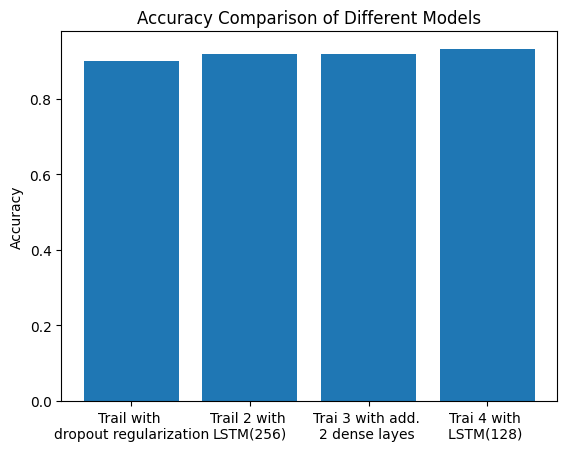

In [43]:
import matplotlib.pyplot as plt
model_labels = ['Trail with \ndropout regularization', 'Trail 2 with \nLSTM(256)', 'Trai 3 with add. \n2 dense layes ', 'Trai 4 with \nLSTM(128) ']

# Bar positions on the x-axis
x_pos = range(len(model_labels))

# Accuracy values
accuracy_values = [accuracy2, accuracy1, accuracy3,accuracy4]

# Create the bar plot
plt.bar(x_pos, accuracy_values, align='center')

# Set the x-axis ticks and labels
plt.xticks(x_pos, model_labels)

# Set the y-axis label
plt.ylabel('Accuracy')

# Set the plot title
plt.title('Accuracy Comparison of Different Models')

# Display the plot
plt.show()

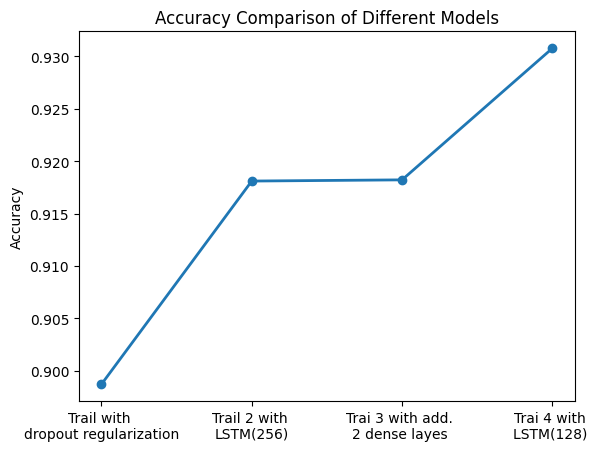

In [45]:

x_values = range(len(model_labels))
y_values = [accuracy2, accuracy1, accuracy3,accuracy4]

# Create the line plot
plt.plot(x_values, y_values, marker='o', linestyle='-', linewidth=2)

# Set the x-axis ticks and labels
plt.xticks(x_values, model_labels)

# Set the y-axis label
plt.ylabel('Accuracy')

# Set the plot title
plt.title('Accuracy Comparison of Different Models')

# Display the plot
plt.show()